# Killer shrimp challenge
The goal of the challenge is to predict the presence of _Dikerogammarus Villosus_ and its spread in the Baltic Sea. D. Villosus is called "Killer Shrimp" and it's an invasive species.

### Dataset
The dataset contains the following variables:
- Presence = 0 or 1
- Salinity_today = water salinity at surface (0-2 meters, mean value over winter months, in parts per 1000)
- Temperature_today = water temperature at surface (mean value over winter months, in C)
- Substrate = substrate type (1 = sand, 0 = no sand)
- Depth = Depth of ocean
- Exposure = Wave exposure index at surface

### Output
The output dataset must contain pointid and predicted presence.

## Approach
Since this is a classification problem, I intend to use it as a learning tool to try to implement a Support Vector Machine model. This is something I read about but I never had the time to dive in it. It should be fun.

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm

### Data visualization

In [18]:
train_data_raw = pd.read_csv('../Datasets/killer-shrimp-invasion/train.csv')
test_data_raw = pd.read_csv('../Datasets/killer-shrimp-invasion/test.csv')

In [19]:
train_data_raw.shape[0] == train_data_raw.dropna().shape[0]

False

The dataset contains some NA. For now we simply drop the NA:

In [21]:
train_data = train_data_raw.dropna()

,pointid,Salinity_today,Temperature_today,Substrate,Depth,Exposure,Presence
0,1557521,30.467175,6.472158,1.0,-124.810000,972065.250,0
1,893106,5.571699,3.367225,0.0,-6.122131,19108.832,0
2,1326854,6.657795,5.305255,1.0,-162.640000,772179.300,0
3,196477,2.744422,1.934046,0.0,-35.440000,407472.400,0
4,168448,2.797321,2.039138,1.0,-51.250000,408049.120,0
...,...,...,...,...,...,...,...
2626039,137786,2.852778,2.547727,1.0,-54.860000,479441.900,0
2626040,2351992,7.273593,5.839776,1.0,-47.790000,716078.300,0
2626041,2646141,5.569929,2.746445,1.0,-4.230000,10185.000,0
2626042,516492,5.057734,3.593806,1.0,-89.640000,806263.700,0


Separate features and labels:

In [28]:
features = ['Salinity_today', 'Temperature_today', 'Substrate', 'Depth', 'Exposure']
train_features = train_data[features]
test_features = test_data_raw[features]
train_labels = train_data['Presence']

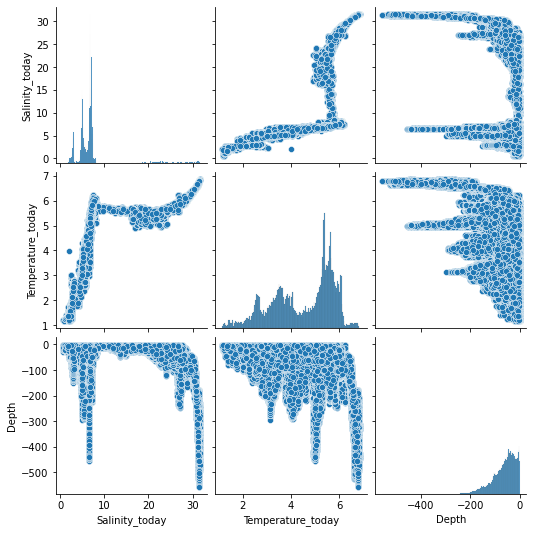

In [32]:
sns.pairplot(train_features[['Salinity_today', 'Temperature_today', 'Depth']], diag_kind='hist')

From a first visualization of data, it seems that there are some values with more entries than others. I will try to implement the support vector machine blindly, as a start.

In [37]:
model = svm.SVC()
model.fit(train_features, train_labels)

SVC()

And then we produce the prediction:

In [40]:
predictions = model.predict(test_features.dropna())

The problem with this is that I had to drop NaNs in order to do it. Submission has to be full. Another solution will be needed...